In [1]:
import pandas as pd
import numpy as np
import scipy
import csv
import os
import math
import collections
import scipy.stats
import statsmodels.api as sm
import subprocess
import re
import seaborn as sns

from lifelines import CoxPHFitter
from tqdm import tqdm

from lifelines.utils import k_fold_cross_validation
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split 
from statsmodels.stats.weightstats import ztest
from scipy import interp
from functools import reduce 

## Creazione dei dataset da Excel

In [2]:
sens=pd.read_csv('clintab_GMQL/miRNA/ss_surv_miRNA.csv', sep='\t')
sens['class']=np.zeros(sens.shape[0], dtype=int)
#sens.head()

In [3]:
senl=pd.read_csv('clintab_GMQL/miRNA/sl_surv_miRNA.csv', sep='\t')
senl['class']=np.full(senl.shape[0], 2)
#senl.head()

In [4]:
res=pd.read_csv('clintab_GMQL/miRNA/res_surv_miRNA.csv', sep='\t')
res['class']=np.ones(res.shape[0], dtype=int)
#res.head()

In [5]:
sensitive=senl.append(sens, ignore_index=True)
all_dset1=res.append(sensitive, ignore_index=True)

all_dset1.head()

,patient,chrom,start,stop,mirna_id,rpm,entrez_id,gene_symbol,pfs,pfi,os,event,class
0,R_00000,1,17369,17436,hsa-mir-6859-1,0.0000,102466751.0,mir6859-1,5.934426,1.3,29.967213,1,1
1,R_00000,1,30366,30503,hsa-mir-1302-2,0.0000,100302278.0,mir1302-2,5.934426,1.3,29.967213,1,1
2,R_00000,1,187891,187958,hsa-mir-6859-2,0.0000,102465909.0,mir6859-2,5.934426,1.3,29.967213,1,1
3,R_00000,1,632325,632413,hsa-mir-6723,0.0000,102465432.0,mir6723,5.934426,1.3,29.967213,1,1
4,R_00000,1,1167104,1167198,hsa-mir-200b,616.4248,406984.0,mir200b,5.934426,1.3,29.967213,1,1


In [23]:
chrom1=all_dset1.loc[all_dset1.chrom == '1']
chrom_1=chrom1.pivot(index="patient", columns="mirna_id", values="rpm")
genes = chrom_1.columns.tolist()
chrom_1.loc[:, (chrom_1 != 0.0).any(axis=0)]
chr1=chrom_1.replace(0,np.nan).dropna(axis=1,how="any")
#chr1.head()

In [26]:
y=chr1.copy()
y=y.drop(['hsa-mir-181b-1', 'hsa-mir-1976', 'hsa-mir-200b', 'hsa-mir-214', 'hsa-mir-30e'], axis=1)

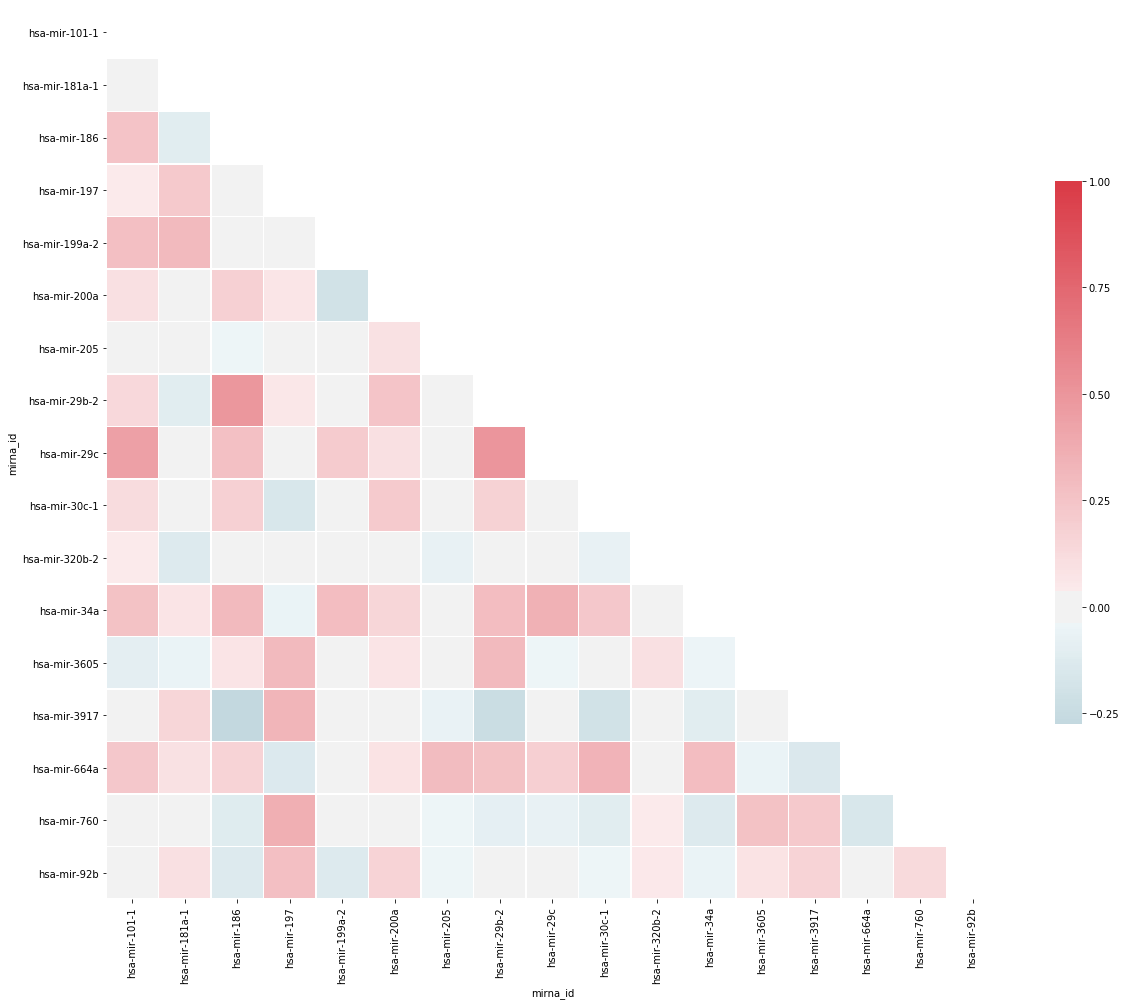

In [27]:
import seaborn as sns
corr = y.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(20, 20))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns_plot=sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
#sns_plot.figure.savefig("miRNA_correlation_matrix_mildFDR.png")

## Significant features

In [35]:
a=pd.read_csv("new_data/miRNA/res_sl_bh.csv", delimiter=',')
b=pd.read_csv("new_data/miRNA/res_ss_bh.csv", delimiter=',')
c=pd.read_csv("new_data/miRNA/sl_ss_bh.csv", delimiter=',')

In [36]:
tot=a.append(c, ignore_index=True, sort=True)
all_genes=tot.append(b, ignore_index=True, sort=True)
#all_genes.head()
#all_genes.shape

In [37]:
ciao = all_genes[all_genes.columns[0:1]] 
#ciao.head()
ciao.shape

(334, 1)

### Dataset from list of significant genes

In [38]:
lista1=set(all_genes['gene'])
len(lista1)

260

In [39]:
dset_res = res[res.mirna_id.isin(lista1)]
res1=pd.DataFrame(dset_res)
#res1.head()
res1.shape

(21320, 13)

In [40]:
resdf=res1.pivot(index="patient", columns="mirna_id", values="rpm")
genes = resdf.columns.tolist()
resdf.loc[:, (resdf != 0.0).any(axis=0)]
#resdf.head()
resdf.shape

(82, 260)

In [41]:
dset_sens = sens[sens.mirna_id.isin(lista1)]
sens1=pd.DataFrame(dset_sens)
#sens1.head()
sens1.shape

(36920, 13)

In [42]:
sensdf=sens1.pivot(index="patient", columns="mirna_id", values="rpm")
sensdf = sensdf[genes]
sensdf.loc[:, (sensdf != 0.0).any(axis=0)]
#sensdf.head()
sensdf.shape

(142, 260)

In [43]:
dset_senl = senl[senl.mirna_id.isin(lista1)]
senl1=pd.DataFrame(dset_senl)
#senl1.head()

In [44]:
senldf=senl1.pivot(index="patient", columns="mirna_id", values="rpm")
senldf = senldf[genes]
senldf.loc[:, (senldf != 0.0).any(axis=0)]
#senldf.head()
senldf.shape

(40, 260)

In [45]:
sen_conc=pd.concat([senldf, sensdf])
all_conc=pd.concat([sen_conc, resdf])

In [46]:
#all_conc.shape
all_conc.head()

mirna_id,hsa-mir-1-1,hsa-mir-106b,hsa-mir-1180,hsa-mir-1185-2,hsa-mir-1193,hsa-mir-1226,hsa-mir-124-2,hsa-mir-1243,hsa-mir-1250,hsa-mir-1253,...,hsa-mir-7151,hsa-mir-760,hsa-mir-764,hsa-mir-7705,hsa-mir-7845,hsa-mir-7849,hsa-mir-877,hsa-mir-933,hsa-mir-934,hsa-mir-938
patient,,,,,,,,,,,,,,,,,,,,,
SL_00000,1.049559,1879.760407,282.331407,0.000000,0.0,113.352386,0.0,0.0,0.000000,0.0,...,0.000000,19.941624,0.0,0.0,2.099118,0.000000,30.437215,0.0,0.000000,0.0
SL_00001,0.000000,2763.277416,845.622901,0.000000,0.0,360.071687,0.0,0.0,0.000000,0.0,...,0.000000,125.479527,0.0,0.0,5.455632,0.000000,57.284132,0.0,0.000000,0.0
SL_00002,0.000000,1128.734369,99.946256,0.000000,0.0,89.173606,0.0,0.0,0.000000,0.0,...,0.000000,131.067246,0.0,0.0,3.590883,0.598481,22.742262,0.0,0.000000,0.0
SL_00003,0.000000,3126.448982,255.479578,0.000000,0.0,61.399788,0.0,0.0,0.000000,0.0,...,0.000000,86.100852,0.0,0.0,0.000000,0.000000,45.167660,0.0,1.411489,0.0
SL_00004,0.000000,1424.948386,192.455823,0.228028,0.0,29.871698,0.0,0.0,0.684085,0.0,...,0.912113,54.954803,0.0,0.0,1.596198,0.000000,32.836065,0.0,7.752960,0.0


In [47]:
all_conc=all_conc.replace(0,np.nan).dropna(axis=1,how="any")
all_conc.head()

mirna_id,hsa-mir-106b,hsa-mir-1180,hsa-mir-1226,hsa-mir-128-1,hsa-mir-128-2,hsa-mir-1287,hsa-mir-1301,hsa-mir-1306,hsa-mir-1307,hsa-mir-130b,...,hsa-mir-501,hsa-mir-502,hsa-mir-532,hsa-mir-550a-1,hsa-mir-584,hsa-mir-589,hsa-mir-652,hsa-mir-675,hsa-mir-760,hsa-mir-877
patient,,,,,,,,,,,,,,,,,,,,,
SL_00000,1879.760407,282.331407,113.352386,47.230161,11.545150,24.139860,119.649741,121.748859,8138.281515,51.428398,...,219.357859,20.991183,1383.318937,7.346914,25.189419,101.807236,18.892064,115.451505,19.941624,30.437215
SL_00001,2763.277416,845.622901,360.071687,226.408712,84.562290,46.372869,124.570255,132.753703,12823.462126,279.146485,...,122.751711,18.185439,1903.106164,8.183447,40.007965,642.855259,34.552334,462.819416,125.479527,57.284132
SL_00002,1128.734369,99.946256,89.173606,85.582723,37.105796,46.681485,102.938659,58.052616,7761.096129,120.893077,...,135.855091,14.962014,1061.704545,12.568092,11.969612,402.178948,182.536576,83.787281,131.067246,22.742262
SL_00003,3126.448982,255.479578,61.399788,171.495960,75.514682,43.050426,252.656599,358.518303,20611.979452,55.753831,...,340.874686,38.110213,1401.608957,14.114894,14.114894,819.369586,208.194684,32.464256,86.100852,45.167660
SL_00004,1424.948386,192.455823,29.871698,315.819093,239.885694,75.705371,79.809879,54.042690,4068.707641,50.394238,...,84.826500,11.629440,894.782760,10.261270,157.795533,148.674404,104.892984,19.838456,54.954803,32.836065


### Adding pfs, class, event, overall survival, pfi

In [48]:
lista2=set(all_dset1['pfs'])
lista3=set(all_dset1['event'])
lista4=set(all_dset1['pfi'])
lista5=set(all_dset1['os'])

In [49]:
gr=all_dset1.groupby(['patient'])

In [50]:
pfs=[]
e=[]
os=[]
pfi=[]
#classes=[]
for p in gr.groups.keys():
    g=gr.get_group(p)
    pfs.append(g['pfs'].unique()[0])
    e.append(g['event'].unique()[0])
    os.append(g['os'].unique()[0])
    pfi.append(g['pfi'].unique()[0])
    #classes.append(g['class'].unique()[0])
   

In [51]:
all_conc['pfs']=pfs
all_conc['event']=e
all_conc['ov_sur']=os
all_conc['pfi']=pfi
#all_conc['class']=classes

all_conc.head()

mirna_id,hsa-mir-106b,hsa-mir-1180,hsa-mir-1226,hsa-mir-128-1,hsa-mir-128-2,hsa-mir-1287,hsa-mir-1301,hsa-mir-1306,hsa-mir-1307,hsa-mir-130b,...,hsa-mir-584,hsa-mir-589,hsa-mir-652,hsa-mir-675,hsa-mir-760,hsa-mir-877,pfs,event,ov_sur,pfi
patient,,,,,,,,,,,,,,,,,,,,,
SL_00000,1879.760407,282.331407,113.352386,47.230161,11.545150,24.139860,119.649741,121.748859,8138.281515,51.428398,...,25.189419,101.807236,18.892064,115.451505,19.941624,30.437215,5.934426,1,29.967213,1.300000
SL_00001,2763.277416,845.622901,360.071687,226.408712,84.562290,46.372869,124.570255,132.753703,12823.462126,279.146485,...,40.007965,642.855259,34.552334,462.819416,125.479527,57.284132,7.967213,1,19.934426,1.900546
SL_00002,1128.734369,99.946256,89.173606,85.582723,37.105796,46.681485,102.938659,58.052616,7761.096129,120.893077,...,11.969612,402.178948,182.536576,83.787281,131.067246,22.742262,10.491803,1,30.131148,5.125137
SL_00003,3126.448982,255.479578,61.399788,171.495960,75.514682,43.050426,252.656599,358.518303,20611.979452,55.753831,...,14.114894,819.369586,208.194684,32.464256,86.100852,45.167660,11.049180,1,18.622951,3.600000
SL_00004,1424.948386,192.455823,29.871698,315.819093,239.885694,75.705371,79.809879,54.042690,4068.707641,50.394238,...,157.795533,148.674404,104.892984,19.838456,54.954803,32.836065,9.049180,1,41.934426,1.900000


In [ ]:
y=all_conc.copy()
y=y.drop(['ov_sur', 'pfi', 'pfs', 'event', 'hsa-mir-16-2', 'hsa-mir-181d', 'hsa-mir-222', 'hsa-mir-500a',
         'hsa-mir-500b', 'hsa-mir-501', 'hsa-mir-502', 'hsa-mir-128-2', 'hsa-mir-23b'], axis=1)
#x.head()

In [ ]:
import seaborn as sns
corr = y.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(30, 30))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns_plot=sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
sns_plot.figure.savefig("miRNA_correlation_matrix_mildFDR.png")

In [52]:
x=all_conc.copy()
x=x.drop(['ov_sur', 'pfi', 'hsa-mir-16-2', 'hsa-mir-181d', 'hsa-mir-222', 'hsa-mir-500a', 'hsa-mir-500b', 'hsa-mir-501', 
          'hsa-mir-502', 'hsa-mir-128-2', 'hsa-mir-23b', 'hsa-mir-1226','hsa-mir-1287','hsa-mir-183','hsa-mir-652',
          'hsa-mir-29a','hsa-mir-1301','hsa-mir-589','hsa-mir-584','hsa-mir-296','hsa-mir-3200','hsa-mir-877','hsa-mir-1306',
          'hsa-mir-423','hsa-mir-185','hsa-mir-345','hsa-mir-4758','hsa-mir-338','hsa-mir-16-1','hsa-mir-675','hsa-mir-342',
          'hsa-mir-106b','hsa-mir-128-1','hsa-mir-181c'], axis=1)

In [24]:
from sklearn.model_selection import train_test_split
x_new=x.copy()
x_new=x_new.drop('pfs', axis=1)
X_train, X_test, y_train, y_test = train_test_split(x_new, x['pfs'], test_size=0.2)
X_train['pfs']= y_train
X_test['pfs']= y_test

/home/lalli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/lalli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [25]:
cph = CoxPHFitter(penalizer=0.1)
cph.fit(X_train, 'pfs', event_col='event', show_progress=True)


Iteration 1: norm_delta = 0.33484, step_size = 0.9500, ll = -836.62637, newton_decrement = 9.49719, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.06394, step_size = 0.9500, ll = -828.34870, newton_decrement = 0.42406, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.00678, step_size = 0.9500, ll = -827.91445, newton_decrement = 0.00445, seconds_since_start = 0.0
Iteration 4: norm_delta = 0.00040, step_size = 1.0000, ll = -827.91005, newton_decrement = 0.00001, seconds_since_start = 0.1
Iteration 5: norm_delta = 0.00000, step_size = 1.0000, ll = -827.91004, newton_decrement = 0.00000, seconds_since_start = 0.1Convergence completed after 5 iterations.


<lifelines.CoxPHFitter: fitted with 211 observations, 28 censored>

In [26]:
res=[]
sens=[]
senl=[]

for p in X_test.index:
    if 'R' in p:
        res.append(p)
    elif 'SS' in p:
        sens.append(p)
    else:
        senl.append(p)

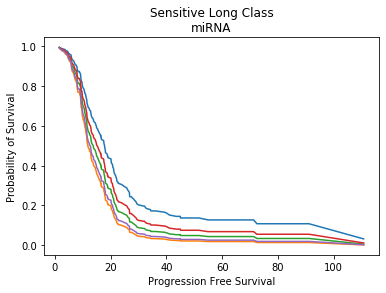

In [29]:
plt.plot(cph.predict_survival_function(X_test.loc[senl]))
plt.xlabel('Progression Free Survival')
plt.ylabel('Probability of Survival')
plt.title('Sensitive Long Class\nmiRNA')
plt.show()

In [53]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
print(scaler.fit(x))
StandardScaler(copy=True, with_mean=True, with_std=True)
print(scaler.mean_)
df_scal=scaler.transform(x)
df_scal=pd.DataFrame(df_scal, columns=x.columns)
#print(df_scal)

StandardScaler(copy=True, with_mean=True, with_std=True)
[2.32849108e+02 9.21358483e+03 7.08400734e+01 2.44378899e+02
 4.39496858e+03 8.78791670e+02 4.44774109e+02 6.67207686e+01
 1.05177998e+03 1.92550522e+03 1.06985446e+01 5.84768450e+01
 2.07771982e+01 8.67424242e-01]


In [54]:
cph = CoxPHFitter(penalizer=0.0001)
cph.fit(df_scal, duration_col='pfs', event_col='event', show_progress=True, step_size=0.050)
cph.print_summary()
cph.baseline_cumulative_hazard_.shape

Iteration 21: norm_delta = 0.00000, step_size = 1.0000, ll = -1202.48609, newton_decrement = 0.00000, seconds_since_start = 0.5Convergence completed after 21 iterations.
<lifelines.CoxPHFitter: fitted with 264 observations, 0 censored>
      duration col = 'pfs'
         event col = 'event'
         penalizer = 0.0001
number of subjects = 264
  number of events = 264
partial log-likelihood = -1202.49
  time fit was run = 2019-10-16 09:02:08 UTC

---
                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
mirna_id                                                                                                        
hsa-mir-1180    0.11      1.11      0.07           -0.04            0.25                0.96                1.29
hsa-mir-1307    0.01      1.01      0.07           -0.14            0.15                0.87                1.16
hsa-mir-130b    0.05      1.05      0.07           -0.09            0.18                0.92  

(232, 1)

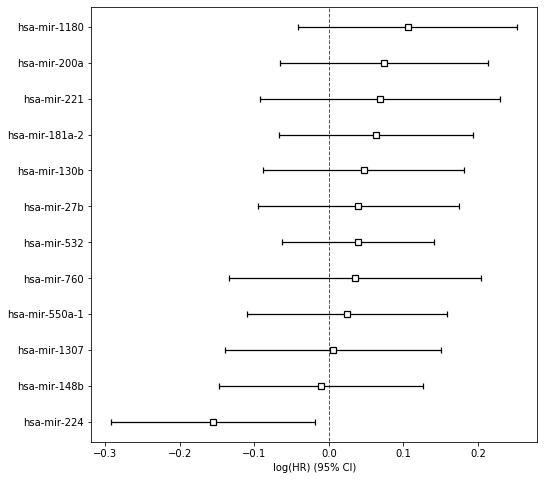

In [56]:
plt.rcParams["figure.figsize"] = [8, 8]
cph.plot()

In [ ]:
k_fold = k_fold_cross_validation(cph, df_scal, duration_col='pfs', event_col='event', k=5, predictor='predict_median')

In [ ]:
w=np.mean(k_fold)
w
#k_fold

In [ ]:
k_fold

## Prove

In [ ]:
cph.fit(all_conc, duration_col='pfs', event_col='event', show_progress=True)

cph.plot_covariate_groups('ENSG00000135443.7', [0, 1, 2], cmap='coolwarm')

In [ ]:
#prediction(?)

from lifelines import WeibullAFTFitter
aft_with_elastic_penalty = WeibullAFTFitter(penalizer=4.0, l1_ratio=1.0)
aft_with_elastic_penalty.fit(all_conc, 'pfs', 'event')
aft_with_elastic_penalty.predict_median(all_conc)

aft_with_elastic_penalty.print_summary()

In [ ]:
#Model selection for AFT models
from lifelines import LogLogisticAFTFitter, WeibullAFTFitter, LogNormalAFTFitter

llf = LogLogisticAFTFitter().fit(all_conc, 'pfs', 'event')
lnf = LogNormalAFTFitter().fit(all_conc, 'pfs', 'event')
wf = WeibullAFTFitter().fit(all_conc, 'pfs', 'event')

print(llf.log_likelihood_) 
print(lnf.log_likelihood_)  
print(wf.log_likelihood_)   


# with some heterogeneity in the ancillary parameters
#ancillary_df = all_conc[['class']]
#llf = LogLogisticAFTFitter().fit(all_conc, 'pfs', 'event', ancillary_df=ancillary_df)
#lnf = LogNormalAFTFitter().fit(all_conc, 'pfs', 'event', ancillary_df=ancillary_df)
#wf = WeibullAFTFitter().fit(all_conc, 'pfs', 'event', ancillary_df=ancillary_df)

#print(llf.log_likelihood_) 
#print(lnf.log_likelihood_) 
#print(wf.log_likelihood_)  

In [ ]:
all_conc['ENSG00000135443.7']

In [ ]:
cph.check_assumptions(all_conc, p_value_threshold=0.05, show_plots=True)